## Install packages

In [1]:
!pip install findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports and Env

In [47]:
from sklearn.decomposition import SparsePCA
import seaborn as sns
import pandas as pd

In [45]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
import findspark
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.column import _to_java_column, _to_seq, Column
from pyspark.sql import SparkSession
from pyspark.ml.feature import IDFModel, IDF, PCA, VectorAssembler
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.types import StructType, StringType, IntegerType, FloatType, BooleanType, ArrayType
from pyspark.ml.feature import CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import pyspark.sql.functions as sqlf

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import os

In [7]:
os.getcwd()

'/content'

In [8]:
os.chdir('drive/MyDrive/SteamReviews2021Project')

In [9]:
os.listdir()

['data',
 'BDA_Project_Preprocessing.ipynb',
 'models',
 'Preprocessing+tokenization.ipynb',
 'Plotting_vectorization.ipynb']

# Constants

In [10]:
non_null_schema = StructType() \
    .add("#", IntegerType(), True) \
    .add("app_id", IntegerType(), True) \
    .add("app_name", StringType(), True) \
    .add("review_id", IntegerType(), True) \
    .add("language", StringType(), True) \
    .add("review", StringType(), True) \
    .add("timestamp_created", IntegerType(), True) \
    .add("timestamp_updated", IntegerType(), True) \
    .add("recommended", BooleanType(), True) \
    .add("votes_helpful", IntegerType(), True) \
    .add("votes_funny", IntegerType(), True) \
    .add("weighted_vote_score", FloatType(), True) \
    .add("comment_count", IntegerType(), True) \
    .add("steam_purchase", BooleanType(), True) \
    .add("received_for_free", BooleanType(), True) \
    .add("written_during_early_access", BooleanType(), True) \
    .add("author_steamid", IntegerType(), True) \
    .add("author_num_games_owned", IntegerType(), True) \
    .add("author_num_reviews", IntegerType(), True) \
    .add("author_playtime_forever", FloatType(), True) \
    .add("author_playtime_last_two_weeks", FloatType(), True) \
    .add("author_playtime_at_review", FloatType(), True) \
    .add("author_last_played", IntegerType(), True)

In [11]:
INDEX = "#"
APP_ID = "app_id"
APP_NAME = "app_name"
REVIEW_ID = "review_id"
LANGUAGE = "language"
REVIEW = "review"
TIMESTAMP_CREATED = "timestamp_created"
TIMESTAMP_UPDATED = "timestamp_updated"
RECOMMENDED = "recommended"
VOTES_HELPFUL = "votes_helpful"
VOTES_FUNNY = "votes_funny"
WEIGHTED_VOTE_SCORE = "weighted_vote_score"
COMMENT_COUNT = "comment_count"
STEAM_PURCHASE = "steam_purchase"
RECEIVED_FOR_FREE = "received_for_free"
WRITTEN_DURING_EARLY_ACCESS = "written_during_early_access"
AUTHOR_STEAMID = "author_steamid"
AUTHOR_NUM_GAMES_OWNED = "author_num_games_owned"
AUTHOR_NUM_REVIEWS = "author_num_reviews"
AUTHOR_PLAYTIME_FOREVER = "author_playtime_forever"
AUTHOR_PLAYTIME_LAST_TWO_WEEKS = "author_playtime_last_two_weeks"
AUTHOR_PLAYTIME_AT_REVIEW = "author_playtime_at_review"
AUTHOR_LAST_PLAYED = "author_last_played"

In [12]:
AUX_COL = "aux"

In [13]:
vectorization_schema = StructType() \
    .add("review_id", IntegerType(), True) \
    .add("recommended", IntegerType(), True) \
    .add("review", VectorUDT(), True)

# Load Vectorization

In [14]:
findspark.init()
spark = SparkSession.builder.master("local") \
                    .appName("Plotting vectorizations") \
                    .config("spark.executor.cores", "8") \
                    .config("spark.executor.memory", "8g") \
                    .getOrCreate()

In [15]:
DATASET_PATH = "data/idf_tokenization/idf_dataset.json"

In [16]:
df = spark.read.option("encoding", "utf-8") \
      .schema(vectorization_schema) \
      .json(DATASET_PATH)

In [17]:
df.show(5, truncate=False)

+---------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_id|recommended|review                                                                                                                                                                                                                                                     |
+---------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|84222416 |1          |(10817,[3,4,6,184,1684],[1.8212661372761738,1.8786432498594763,2.04301660733421,4.454146794999703,6.905151893112022])                                

# Plot

## PCA

In [18]:
df = df.toPandas()

In [19]:
df.head(5)

,review_id,recommended,review
0,84222416,1,"(0.0, 0.0, 0.0, 1.8212661372761738, 1.87864324..."
1,83056151,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0430166073342..."
2,82605667,0,"(0.6855562531787913, 0.0, 1.698401720089476, 0..."
3,82535616,1,"(0.6855562531787913, 0.0, 0.0, 1.8212661372761..."
4,82520252,1,"(0.0, 0.0, 1.698401720089476, 1.82126613727617..."


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    9973 non-null   int32 
 1   recommended  9973 non-null   int32 
 2   review       9973 non-null   object
dtypes: int32(2), object(1)
memory usage: 156.0+ KB


In [21]:
df.iloc[0][REVIEW]

SparseVector(10817, {3: 1.8213, 4: 1.8786, 6: 2.043, 184: 4.4541, 1684: 6.9052})

In [50]:
df_sample = pd.concat([df[df[RECOMMENDED]==True].head(100), df[df[RECOMMENDED]==False].head(100)])

In [53]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 487
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    200 non-null    int32 
 1   recommended  200 non-null    int32 
 2   review       200 non-null    object
dtypes: int32(2), object(1)
memory usage: 4.7+ KB


In [54]:
transformer = SparsePCA(n_components=2, random_state=0)

In [55]:
transformer.fit(df_sample[REVIEW].tolist())

SparsePCA(n_components=2, random_state=0)

In [56]:
pca_features = transformer.transform(df_sample[REVIEW].tolist())

In [57]:
df_plot = df_sample.copy()

In [58]:
df_plot["pca0"] = pca_features[:,0]

In [59]:
df_plot["pca1"] =pca_features[:,1]

In [60]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 487
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    200 non-null    int32  
 1   recommended  200 non-null    int32  
 2   review       200 non-null    object 
 3   pca0         200 non-null    float64
 4   pca1         200 non-null    float64
dtypes: float64(2), int32(2), object(1)
memory usage: 7.8+ KB


## Scatter Plot

In [62]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 487
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    200 non-null    int32  
 1   recommended  200 non-null    int32  
 2   review       200 non-null    object 
 3   pca0         200 non-null    float64
 4   pca1         200 non-null    float64
dtypes: float64(2), int32(2), object(1)
memory usage: 7.8+ KB


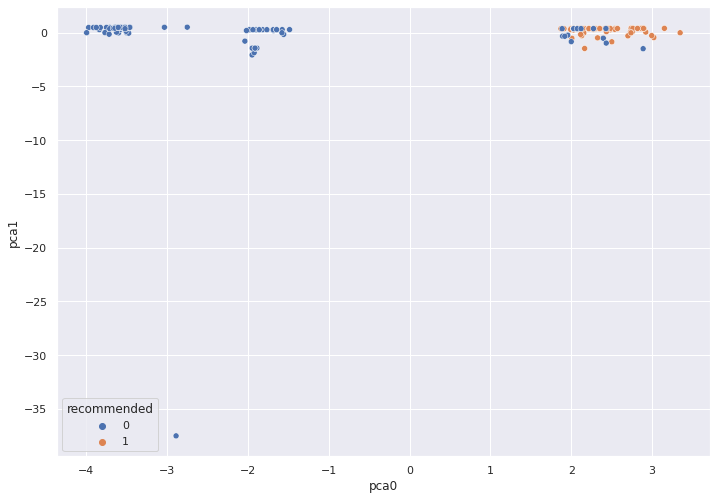

In [63]:
sns.scatterplot(data=df_plot, x="pca0", y="pca1", hue=RECOMMENDED)

#PCA

In [21]:
# pca = PCA(k=2, inputCol=REVIEW, outputCol=AUX_COL)

In [22]:
# pca.fit(df_plot_sample)

Py4JJavaError: ignored